In [1]:
# NLP Sentiment Analysis & Emotion Classification with Transformer Models
# Comparing BERT, DistilBERT, and GPT models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import pipeline
from datasets import Dataset, DatasetDict

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")

# Set random seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)

2025-04-21 19:36:39.356372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745264199.550460      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745264199.605699      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
PyTorch version: 2.5.1+cu124
Transformers version: 4.51.1


In [2]:
# Load Datasets
print("Loading datasets...")

# Load Amazon Reviews Sentiment Dataset
amazon_reviews = pd.read_csv("/kaggle/input/amazone-reviews/amazon_reviews.csv")
print("Amazon Reviews Dataset shape:", amazon_reviews.shape)
print(amazon_reviews.head())

# Load Emotions Dataset
emotions = pd.read_csv("/kaggle/input/emotions-dataset/emotions.csv")
print("Emotions Dataset shape:", emotions.shape)
print(emotions.head())

# Load Unlabelled Amazon Reviews
unlabelled_reviews = pd.read_csv("/kaggle/input/amazon/amazon_reviews.csv")
print("Unlabelled Reviews Dataset shape:", unlabelled_reviews.shape)
print(unlabelled_reviews.head())

Loading datasets...
Amazon Reviews Dataset shape: (400000, 2)
                                              Review  Label
0  Great CD: My lovely Pat has one of the GREAT v...      1
1  One of the best game music soundtracks - for a...      1
2  Batteries died within a year ...: I bought thi...      0
3  works fine, but Maha Energy is better: Check o...      1
4  Great for the non-audiophile: Reviewed quite a...      1
Emotions Dataset shape: (416809, 2)
                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4
Unlabelled Reviews Dataset shape: (4915, 12)
   Unnamed: 0  reviewerName  overall  \
0           0           NaN      4.0   
1           1          0mie      5.0   
2           2    

In [3]:
# Data Preprocessing and Exploration

# Amazon Reviews Dataset
print("\nAmazon Reviews Dataset Analysis:")
print(amazon_reviews['Label'].value_counts())
# Check for class balance
sns.countplot(x='Label', data=amazon_reviews)
plt.title('Amazon Reviews - Label Distribution')
plt.savefig('amazon_label_dist.png')
plt.close()

# Emotions Dataset
print("\nEmotions Dataset Analysis:")
print(emotions['label'].value_counts())
# Check for class balance
sns.countplot(x='label', data=emotions)
plt.title('Emotions - Label Distribution')
plt.savefig('emotions_label_dist.png')
plt.close()


Amazon Reviews Dataset Analysis:
Label
1    200000
0    200000
Name: count, dtype: int64

Emotions Dataset Analysis:
label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


In [4]:
# Sampling for efficient training (due to GPU time constraints)
# Using a smaller subset to train multiple models efficiently

# For Amazon Reviews - keeping class balance
amazon_pos = amazon_reviews[amazon_reviews['Label'] == 1].sample(5000, random_state=seed_value)
amazon_neg = amazon_reviews[amazon_reviews['Label'] == 0].sample(5000, random_state=seed_value)
amazon_sample = pd.concat([amazon_pos, amazon_neg]).sample(frac=1, random_state=seed_value).reset_index(drop=True)

# For Emotions - stratified sampling to maintain class distribution
emotions_sample = emotions.groupby('label').apply(lambda x: x.sample(min(1000, len(x)), random_state=seed_value)).reset_index(drop=True)

print(f"Amazon Reviews sample size: {len(amazon_sample)}")
print(f"Emotions sample size: {len(emotions_sample)}")

Amazon Reviews sample size: 10000
Emotions sample size: 6000


/tmp/ipykernel_31/2653444420.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  emotions_sample = emotions.groupby('label').apply(lambda x: x.sample(min(1000, len(x)), random_state=seed_value)).reset_index(drop=True)


In [5]:
# Split into train/validation/test sets
def split_dataset(df, text_col, label_col):
    # Train (70%), validation (15%), test (15%) split
    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df[label_col], random_state=seed_value)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[label_col], random_state=seed_value)
    
    # Convert to Dataset objects
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)
    
    return DatasetDict({
        'train': train_dataset,
        'validation': val_dataset,
        'test': test_dataset
    })

# Process Amazon Reviews for modeling
amazon_datasets = split_dataset(amazon_sample, 'Review', 'Label')

# Process Emotions Dataset for modeling
emotions_datasets = split_dataset(emotions_sample, 'text', 'label')

print("Amazon Reviews datasets:", {k: len(v) for k, v in amazon_datasets.items()})
print("Emotions datasets:", {k: len(v) for k, v in emotions_datasets.items()})

Amazon Reviews datasets: {'train': 7000, 'validation': 1500, 'test': 1500}
Emotions datasets: {'train': 4200, 'validation': 900, 'test': 900}


In [6]:
# Create a model training and evaluation function
def train_evaluate_model(model_name, tokenizer_name, train_dataset, val_dataset, test_dataset, 
                         text_column, label_column, num_labels, output_dir, epochs=3):
    """
    Train and evaluate a model on the given dataset
    """
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    
    # Define tokenization function with labels
    def tokenize_function(examples):
        tokenized = tokenizer(examples[text_column], padding="max_length", truncation=True, max_length=128)
        
        # Add labels to the tokenized output
        tokenized["labels"] = examples[label_column]
        
        return tokenized
    
    # Apply tokenization
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        num_train_epochs=epochs,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'./logs/{model_name}',
        logging_steps=10,
        report_to="none"
    )
    
    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
    )
    
    # Train the model
    print(f"Training {model_name}...")
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Save the model
    trainer.save_model(f"{output_dir}/best_model")
    
    # Evaluate on test set
    print(f"Evaluating {model_name} on test set...")
    start_time = time.time()
    predictions = trainer.predict(tokenized_test)
    inference_time = time.time() - start_time
    
    # Process predictions
    preds = np.argmax(predictions.predictions, axis=1)
    labels = test_dataset[label_column]
    
    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    
    # Generate classification report
    report = classification_report(labels, preds, output_dict=True)
    
    # Generate confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f"{output_dir}/confusion_matrix.png")
    plt.close()
    
    # Process inference time per sample
    avg_inference_time = inference_time / len(test_dataset)
    
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_score': f1,
        'training_time': training_time,
        'inference_time': inference_time,
        'avg_inference_time_per_sample': avg_inference_time,
        'classification_report': report
    }
    
    return model, tokenizer, results

In [7]:
# Function to label unlabelled data
def label_unlabelled_data(model, tokenizer, unlabelled_df, text_column, output_filename):
    """
    Label unlabelled data using a trained model
    """
    # Create a pipeline
    nlp = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device if device.type == 'cuda' else -1, truncation=True, max_length=512)
    
    # Start timing
    start_time = time.time()
    
    # Process in batches to avoid memory issues
    batch_size = 32
    labels = []
    
    # Convert all values to string - handle all types explicitly
    texts = []
    for item in unlabelled_df[text_column]:
        if pd.isna(item):  # Check for NaN/None values
            texts.append("")
        else:
            texts.append(str(item))  # Convert everything else to string
    
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        # Filter out empty strings
        valid_indices = []
        valid_texts = []
        
        for j, text in enumerate(batch_texts):
            if isinstance(text, str) and text.strip():
                valid_indices.append(j)
                valid_texts.append(text)
        
        if not valid_texts:  # Skip if batch has no valid texts
            # Add default labels for all skipped texts
            labels.extend([0] * len(batch_texts))
            continue
            
        # Process valid texts
        batch_results = nlp(valid_texts)
        
        # Create a list of predicted labels with default value 0
        batch_predictions = [0] * len(batch_texts)
        
        # Replace default values with actual predictions for valid texts
        for idx, result in zip(valid_indices, batch_results):
            batch_predictions[idx] = int(result['label'].split('_')[-1])
            
        labels.extend(batch_predictions)
    
    end_time = time.time()
    inference_time = end_time - start_time
    
    # Add predictions to dataframe
    unlabelled_df['predicted_label'] = labels
    
    # Save to CSV
    unlabelled_df.to_csv(output_filename, index=False)
    
    return unlabelled_df, inference_time

In [8]:
# Train and evaluate BERT model on Amazon Reviews dataset
print("\n======= Training BERT Model on Amazon Reviews Dataset =======")

# BERT model for Amazon Reviews
bert_amazon_model, bert_amazon_tokenizer, bert_amazon_results = train_evaluate_model(
    model_name="bert-base-uncased",
    tokenizer_name="bert-base-uncased",
    train_dataset=amazon_datasets['train'],
    val_dataset=amazon_datasets['validation'],
    test_dataset=amazon_datasets['test'],
    text_column="Review",
    label_column="Label",
    num_labels=2,
    output_dir="./results/amazon/bert",
    epochs=3
)


======= Training BERT Model on Amazon Reviews Dataset =======


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Training bert-base-uncased...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,0.691800
20,0.678200
30,0.687500
40,0.686400
50,0.661200
60,0.649300
70,0.597000
80,0.535200
90,0.465700
100,0.392000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Training completed in 313.76 seconds
Evaluating bert-base-uncased on test set...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [9]:
# Train and evaluate DistilBERT model on Amazon Reviews dataset
print("\n======= Training DistilBERT Model on Amazon Reviews Dataset =======")

# DistilBERT model for Amazon Reviews
distilbert_amazon_model, distilbert_amazon_tokenizer, distilbert_amazon_results = train_evaluate_model(
    model_name="distilbert-base-uncased",
    tokenizer_name="distilbert-base-uncased",
    train_dataset=amazon_datasets['train'],
    val_dataset=amazon_datasets['validation'],
    test_dataset=amazon_datasets['test'],
    text_column="Review",
    label_column="Label",
    num_labels=2,
    output_dir="./results/amazon/distilbert",
    epochs=3
)


======= Training DistilBERT Model on Amazon Reviews Dataset =======


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Training distilbert-base-uncased...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,0.708000
20,0.713000
30,0.697200
40,0.693600
50,0.682400
60,0.679600
70,0.673300
80,0.632000
90,0.548400
100,0.418400


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Training completed in 165.69 seconds
Evaluating distilbert-base-uncased on test set...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [10]:
# Train and evaluate GPT-2 model on Amazon Reviews dataset
print("\n======= Training GPT-2 Model on Amazon Reviews Dataset =======")

# GPT2 model for Amazon Reviews (with special handling for GPT2)
# GPT2 tokenizer requires padding token to be set
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
model_name = "gpt2"
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.config.pad_token_id = gpt2_tokenizer.eos_token_id

# Define tokenization function for GPT2
def tokenize_gpt2(examples):
    tokenized = gpt2_tokenizer(examples["Review"], padding="max_length", truncation=True, max_length=128)

    # Add labels to the tokenized output
    tokenized["labels"] = examples["Label"]
    
    return tokenized

# Apply tokenization
tokenized_train_gpt2 = amazon_datasets['train'].map(tokenize_gpt2, batched=True)
tokenized_val_gpt2 = amazon_datasets['validation'].map(tokenize_gpt2, batched=True)
tokenized_test_gpt2 = amazon_datasets['test'].map(tokenize_gpt2, batched=True)

# Training arguments for GPT2
training_args_gpt2 = TrainingArguments(
    output_dir=f'./results/{model_name}',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f'./logs/{model_name}',
    logging_steps=100,
    report_to="none"
)

# Initialize Trainer for GPT2
gpt2_trainer = Trainer(
    model=model,
    args=training_args_gpt2,
    train_dataset=tokenized_train_gpt2,
    eval_dataset=tokenized_val_gpt2,
)

# Train GPT2 model
print("Training GPT2 for Amazon Reviews...")
start_time = time.time()
gpt2_trainer.train()
gpt2_training_time = time.time() - start_time
print(f"GPT2 training completed in {gpt2_training_time:.2f} seconds")

# Save the model
gpt2_trainer.save_model("./results/amazon/gpt2/best_model")

# Evaluate GPT2 on test set
print("Evaluating GPT2 on Amazon Reviews test set...")
start_time = time.time()
gpt2_predictions = gpt2_trainer.predict(tokenized_test_gpt2)
gpt2_inference_time = time.time() - start_time

# Process GPT2 predictions
gpt2_preds = np.argmax(gpt2_predictions.predictions, axis=1)
gpt2_labels = amazon_datasets['test']["Label"]

# Calculate metrics for GPT2
gpt2_accuracy = accuracy_score(gpt2_labels, gpt2_preds)
gpt2_f1 = f1_score(gpt2_labels, gpt2_preds, average='weighted')

# Generate classification report for GPT2
gpt2_report = classification_report(gpt2_labels, gpt2_preds, output_dict=True)

# Generate confusion matrix for GPT2
gpt2_cm = confusion_matrix(gpt2_labels, gpt2_preds)

# Plot confusion matrix for GPT2
plt.figure(figsize=(10, 8))
sns.heatmap(gpt2_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GPT2 (Amazon Reviews)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("./results/amazon/gpt2/confusion_matrix.png")
plt.close()

# Process inference time per sample for GPT2
gpt2_avg_inference_time = gpt2_inference_time / len(amazon_datasets['test'])

gpt2_amazon_results = {
    'model_name': "gpt2",
    'accuracy': gpt2_accuracy,
    'f1_score': gpt2_f1,
    'training_time': gpt2_training_time,
    'inference_time': gpt2_inference_time,
    'avg_inference_time_per_sample': gpt2_avg_inference_time,
    'classification_report': gpt2_report
}

# Store GPT2 model and tokenizer for later use
gpt2_amazon_model = model
gpt2_amazon_tokenizer = gpt2_tokenizer


======= Training GPT-2 Model on Amazon Reviews Dataset =======


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Training GPT2 for Amazon Reviews...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,1.003300
200,0.425900
300,0.290100
400,0.277100
500,0.270800
600,0.223800
700,0.211400
800,0.176200
900,0.176800
1000,0.140800


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


GPT2 training completed in 466.44 seconds
Evaluating GPT2 on Amazon Reviews test set...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [11]:
# Train and evaluate BERT model on Emotions dataset
print("\n======= Training BERT Model on Emotions Dataset =======")

# BERT model for Emotions
bert_emotions_model, bert_emotions_tokenizer, bert_emotions_results = train_evaluate_model(
    model_name="bert-base-uncased",
    tokenizer_name="bert-base-uncased",
    train_dataset=emotions_datasets['train'],
    val_dataset=emotions_datasets['validation'],
    test_dataset=emotions_datasets['test'],
    text_column="text",
    label_column="label",
    num_labels=6,
    output_dir="./results/emotions/bert",
    epochs=3
)


======= Training BERT Model on Emotions Dataset =======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Training bert-base-uncased...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1.836200
20,1.826700
30,1.858500
40,1.803700
50,1.797000
60,1.803200
70,1.807300
80,1.795600
90,1.782400
100,1.786500


Training completed in 185.44 seconds
Evaluating bert-base-uncased on test set...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [12]:
# Train and evaluate DistilBERT model on Emotions dataset
print("\n======= Training DistilBERT Model on Emotions Dataset =======")

# DistilBERT model for Emotions
distilbert_emotions_model, distilbert_emotions_tokenizer, distilbert_emotions_results = train_evaluate_model(
    model_name="distilbert-base-uncased",
    tokenizer_name="distilbert-base-uncased",
    train_dataset=emotions_datasets['train'],
    val_dataset=emotions_datasets['validation'],
    test_dataset=emotions_datasets['test'],
    text_column="text",
    label_column="label",
    num_labels=6,
    output_dir="./results/emotions/distilbert",
    epochs=3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======= Training DistilBERT Model on Emotions Dataset =======


Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Training distilbert-base-uncased...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1.796000
20,1.791000
30,1.786900
40,1.799200
50,1.797100
60,1.795700
70,1.778000
80,1.789600
90,1.773600
100,1.751000


Training completed in 97.12 seconds
Evaluating distilbert-base-uncased on test set...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [13]:
# Train and evaluate GPT-2 model on Emotions dataset
print("\n======= Training GPT-2 Model on Emotions Dataset =======")

# GPT2 model for Emotions
model_name = "gpt2"
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=6)
model.config.pad_token_id = gpt2_tokenizer.eos_token_id

# Define tokenization function for GPT2 (Emotions)
def tokenize_gpt2_emotions(examples):
    tokenized = gpt2_tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

    # Add labels to the tokenized output
    tokenized["labels"] = examples["label"]
    
    return tokenized

# Apply tokenization
tokenized_train_gpt2_emotions = emotions_datasets['train'].map(tokenize_gpt2_emotions, batched=True)
tokenized_val_gpt2_emotions = emotions_datasets['validation'].map(tokenize_gpt2_emotions, batched=True)
tokenized_test_gpt2_emotions = emotions_datasets['test'].map(tokenize_gpt2_emotions, batched=True)

# Training arguments for GPT2 (Emotions)
training_args_gpt2_emotions = TrainingArguments(
    output_dir=f'./results/{model_name}',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f'./logs/{model_name}',
    logging_steps=100,
    report_to="none"
)

# Initialize Trainer for GPT2 (Emotions)
gpt2_emotions_trainer = Trainer(
    model=model,
    args=training_args_gpt2_emotions,
    train_dataset=tokenized_train_gpt2_emotions,
    eval_dataset=tokenized_val_gpt2_emotions,
)

# Train GPT2 model for Emotions
print("Training GPT2 for Emotions...")
start_time = time.time()
gpt2_emotions_trainer.train()
gpt2_emotions_training_time = time.time() - start_time
print(f"GPT2 training for Emotions completed in {gpt2_emotions_training_time:.2f} seconds")

# Save the model
gpt2_emotions_trainer.save_model("./results/emotions/gpt2/best_model")

# Evaluate GPT2 on Emotions test set
print("Evaluating GPT2 on Emotions test set...")
start_time = time.time()
gpt2_emotions_predictions = gpt2_emotions_trainer.predict(tokenized_test_gpt2_emotions)
gpt2_emotions_inference_time = time.time() - start_time

# Process GPT2 predictions for Emotions
gpt2_emotions_preds = np.argmax(gpt2_emotions_predictions.predictions, axis=1)
gpt2_emotions_labels = emotions_datasets['test']["label"]

# Calculate metrics for GPT2 on Emotions
gpt2_emotions_accuracy = accuracy_score(gpt2_emotions_labels, gpt2_emotions_preds)
gpt2_emotions_f1 = f1_score(gpt2_emotions_labels, gpt2_emotions_preds, average='weighted')

# Generate classification report for GPT2 on Emotions
gpt2_emotions_report = classification_report(gpt2_emotions_labels, gpt2_emotions_preds, output_dict=True)

# Generate confusion matrix for GPT2 on Emotions
gpt2_emotions_cm = confusion_matrix(gpt2_emotions_labels, gpt2_emotions_preds)

# Plot confusion matrix for GPT2 on Emotions
plt.figure(figsize=(10, 8))
sns.heatmap(gpt2_emotions_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GPT2 (Emotions)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("./results/emotions/gpt2/confusion_matrix.png")
plt.close()

# Process inference time per sample for GPT2 on Emotions
gpt2_emotions_avg_inference_time = gpt2_emotions_inference_time / len(emotions_datasets['test'])

gpt2_emotions_results = {
    'model_name': "gpt2",
    'accuracy': gpt2_emotions_accuracy,
    'f1_score': gpt2_emotions_f1,
    'training_time': gpt2_emotions_training_time,
    'inference_time': gpt2_emotions_inference_time,
    'avg_inference_time_per_sample': gpt2_emotions_avg_inference_time,
    'classification_report': gpt2_emotions_report
}

# Store GPT2 model and tokenizer for Emotions for later use
gpt2_emotions_model = model
gpt2_emotions_tokenizer = gpt2_tokenizer

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======= Training GPT-2 Model on Emotions Dataset =======


Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Training GPT2 for Emotions...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,5.108300
200,1.852100
300,1.334500
400,0.775600
500,0.521900
600,0.358000
700,0.273300


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


GPT2 training for Emotions completed in 276.24 seconds
Evaluating GPT2 on Emotions test set...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



======= Model Performance Comparison =======

Amazon Reviews Models Comparison:
                model_name  accuracy  f1_score  training_time  \
0        bert-base-uncased     0.942  0.942000     313.758557   
1  distilbert-base-uncased     0.920  0.919931     165.689675   
2                     gpt2     0.930  0.930000     466.444345   

   avg_inference_time_per_sample  
0                       0.004324  
1                       0.002208  
2                       0.005700  

Emotions Models Comparison:
                model_name  accuracy  f1_score  training_time  \
0        bert-base-uncased  0.911111  0.910874     185.439779   
1  distilbert-base-uncased  0.902222  0.901371      97.124230   
2                     gpt2  0.931111  0.930716     276.235419   

   avg_inference_time_per_sample  
0                       0.004382  
1                       0.002246  
2                       0.005732  


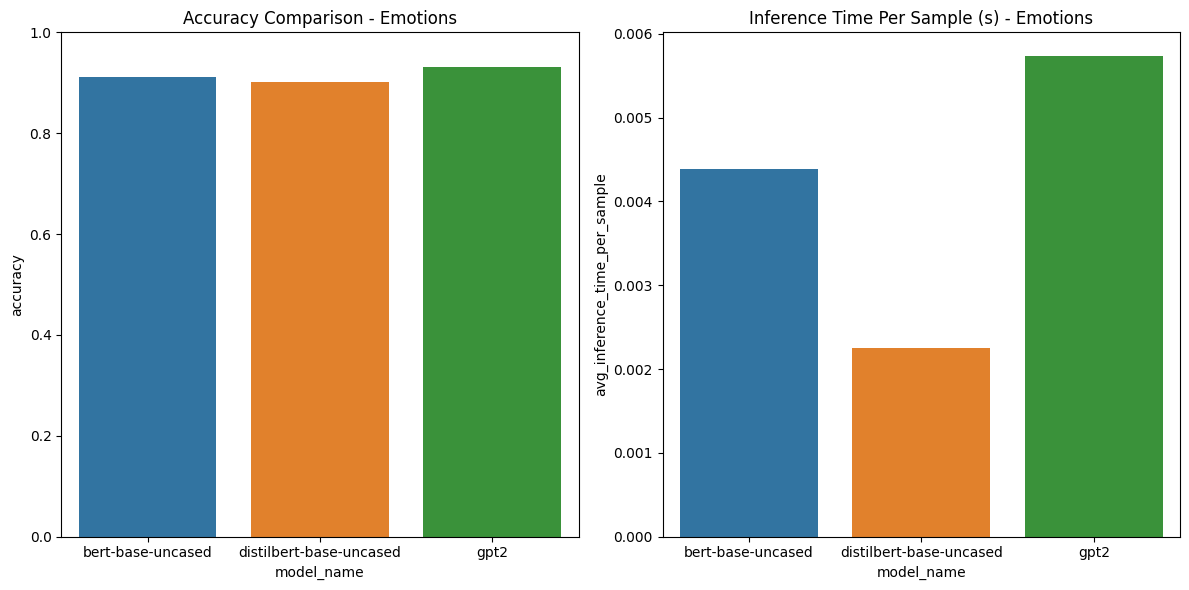

In [14]:
# Compare model performances
print("\n======= Model Performance Comparison =======")

# Amazon Reviews Models Comparison
amazon_models_comparison = pd.DataFrame([
    bert_amazon_results,
    distilbert_amazon_results,
    gpt2_amazon_results
])

# Select only relevant columns for display
amazon_display_cols = ['model_name', 'accuracy', 'f1_score', 'training_time', 'avg_inference_time_per_sample']
print("\nAmazon Reviews Models Comparison:")
print(amazon_models_comparison[amazon_display_cols])

# Create performance comparison plot for Amazon Reviews
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='model_name', y='accuracy', data=amazon_models_comparison)
plt.title('Accuracy Comparison - Amazon Reviews')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
sns.barplot(x='model_name', y='avg_inference_time_per_sample', data=amazon_models_comparison)
plt.title('Inference Time Per Sample (s) - Amazon Reviews')
plt.tight_layout()
plt.savefig("./results/amazon/model_comparison.png")
plt.close()

# Emotions Models Comparison
emotions_models_comparison = pd.DataFrame([
    bert_emotions_results,
    distilbert_emotions_results,
    gpt2_emotions_results
])

print("\nEmotions Models Comparison:")
print(emotions_models_comparison[amazon_display_cols])

# Create performance comparison plot for Emotions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='model_name', y='accuracy', data=emotions_models_comparison)
plt.title('Accuracy Comparison - Emotions')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
sns.barplot(x='model_name', y='avg_inference_time_per_sample', data=emotions_models_comparison)
plt.title('Inference Time Per Sample (s) - Emotions')
plt.tight_layout()
plt.show() 

In [15]:
# Label the unlabelled Amazon reviews using all trained models
print("\n======= Labeling Unlabelled Amazon Reviews =======")

# Check the reviewText column in unlabelled data
text_column = 'reviewText'  # Based on the sample data provided

# Label using BERT for Amazon
bert_labeled_data, bert_labeling_time = label_unlabelled_data(
    model=bert_amazon_model,
    tokenizer=bert_amazon_tokenizer,
    unlabelled_df=unlabelled_reviews,
    text_column=text_column,
    output_filename="./results/bert_labeled_amazon.csv"
)

# Label using DistilBERT for Amazon
distilbert_labeled_data, distilbert_labeling_time = label_unlabelled_data(
    model=distilbert_amazon_model,
    tokenizer=distilbert_amazon_tokenizer,
    unlabelled_df=unlabelled_reviews,
    text_column=text_column,
    output_filename="./results/distilbert_labeled_amazon.csv"
)

# Label using GPT2 for Amazon
gpt2_labeled_data, gpt2_labeling_time = label_unlabelled_data(
    model=gpt2_amazon_model,
    tokenizer=gpt2_amazon_tokenizer,
    unlabelled_df=unlabelled_reviews,
    text_column=text_column,
    output_filename="./results/gpt2_labeled_amazon.csv"
)

Device set to use cuda



======= Labeling Unlabelled Amazon Reviews =======


  0%|          | 0/154 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Device set to use cuda


  0%|          | 0/154 [00:00<?, ?it/s]

Device set to use cuda


  0%|          | 0/154 [00:00<?, ?it/s]


======= Comparing Labeling Results =======
Agreement percentage across all models: 100.00%
BERT vs DistilBERT agreement: 100.00%
BERT vs GPT2 agreement: 100.00%
DistilBERT vs GPT2 agreement: 100.00%


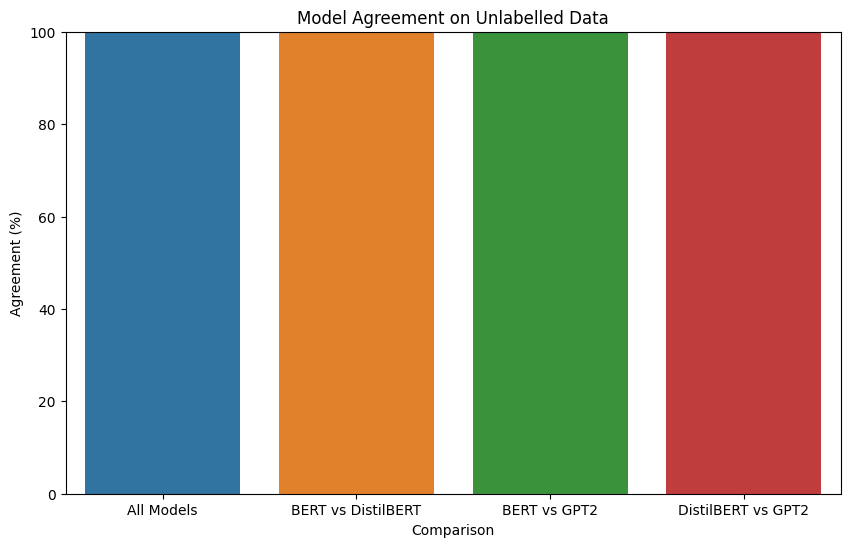

In [16]:
# Compare labeling results across models
print("\n======= Comparing Labeling Results =======")

# Merge the labeled data
comparison_df = unlabelled_reviews.copy()
comparison_df['bert_label'] = bert_labeled_data['predicted_label']
comparison_df['distilbert_label'] = distilbert_labeled_data['predicted_label']
comparison_df['gpt2_label'] = gpt2_labeled_data['predicted_label']

# Calculate agreement percentage
agreement = (comparison_df['bert_label'] == comparison_df['distilbert_label']) & (comparison_df['distilbert_label'] == comparison_df['gpt2_label'])
agreement_percentage = agreement.mean() * 100

print(f"Agreement percentage across all models: {agreement_percentage:.2f}%")

# Compare BERT vs DistilBERT
bert_distilbert_agreement = (comparison_df['bert_label'] == comparison_df['distilbert_label']).mean() * 100
print(f"BERT vs DistilBERT agreement: {bert_distilbert_agreement:.2f}%")

# Compare BERT vs GPT2
bert_gpt2_agreement = (comparison_df['bert_label'] == comparison_df['gpt2_label']).mean() * 100
print(f"BERT vs GPT2 agreement: {bert_gpt2_agreement:.2f}%")

# Compare DistilBERT vs GPT2
distilbert_gpt2_agreement = (comparison_df['distilbert_label'] == comparison_df['gpt2_label']).mean() * 100
print(f"DistilBERT vs GPT2 agreement: {distilbert_gpt2_agreement:.2f}%")

# Save comparison results
comparison_df.to_csv("./results/model_comparison_results.csv", index=False)

# Create visualization of model agreement
agreement_data = pd.DataFrame([
    {'Comparison': 'All Models', 'Agreement (%)': agreement_percentage},
    {'Comparison': 'BERT vs DistilBERT', 'Agreement (%)': bert_distilbert_agreement},
    {'Comparison': 'BERT vs GPT2', 'Agreement (%)': bert_gpt2_agreement},
    {'Comparison': 'DistilBERT vs GPT2', 'Agreement (%)': distilbert_gpt2_agreement}
])

plt.figure(figsize=(10, 6))
sns.barplot(x='Comparison', y='Agreement (%)', data=agreement_data)
plt.title('Model Agreement on Unlabelled Data')
plt.ylim(0, 100)
plt.show()


Labeling Time Comparison:
        Model  Labeling Time (s)  Avg Time Per Sample (s)
0        BERT          43.287763                 0.008807
1  DistilBERT          23.468309                 0.004775
2        GPT2          48.693557                 0.009907


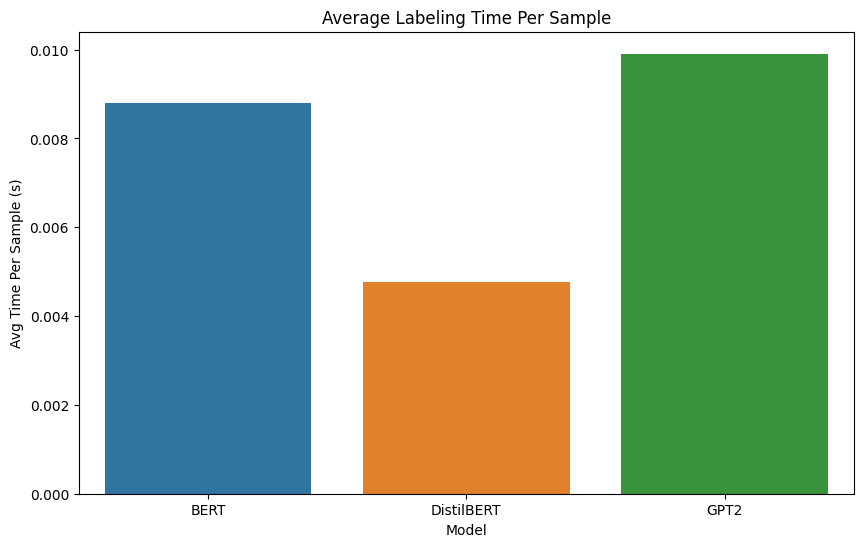

In [17]:
# 11. Calculate labeling time comparison
labeling_time_data = pd.DataFrame([
    {'Model': 'BERT', 'Labeling Time (s)': bert_labeling_time, 'Avg Time Per Sample (s)': bert_labeling_time / len(unlabelled_reviews)},
    {'Model': 'DistilBERT', 'Labeling Time (s)': distilbert_labeling_time, 'Avg Time Per Sample (s)': distilbert_labeling_time / len(unlabelled_reviews)},
    {'Model': 'GPT2', 'Labeling Time (s)': gpt2_labeling_time, 'Avg Time Per Sample (s)': gpt2_labeling_time / len(unlabelled_reviews)}
])

print("\nLabeling Time Comparison:")
print(labeling_time_data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Avg Time Per Sample (s)', data=labeling_time_data)
plt.title('Average Labeling Time Per Sample')
plt.show()


======= Generating Final Summary Report =======

Comprehensive Model Performance Summary:
          Dataset       Model  Accuracy  F1 Score  Training Time (s)  \
0  Amazon Reviews        BERT  0.942000  0.942000         313.758557   
1  Amazon Reviews  DistilBERT  0.920000  0.919931         165.689675   
2  Amazon Reviews        GPT2  0.930000  0.930000         466.444345   
3        Emotions        BERT  0.911111  0.910874         185.439779   
4        Emotions  DistilBERT  0.902222  0.901371          97.124230   
5        Emotions        GPT2  0.931111  0.930716         276.235419   

   Inference Time Per Sample (s)  
0                       0.004324  
1                       0.002208  
2                       0.005700  
3                       0.004382  
4                       0.002246  
5                       0.005732  


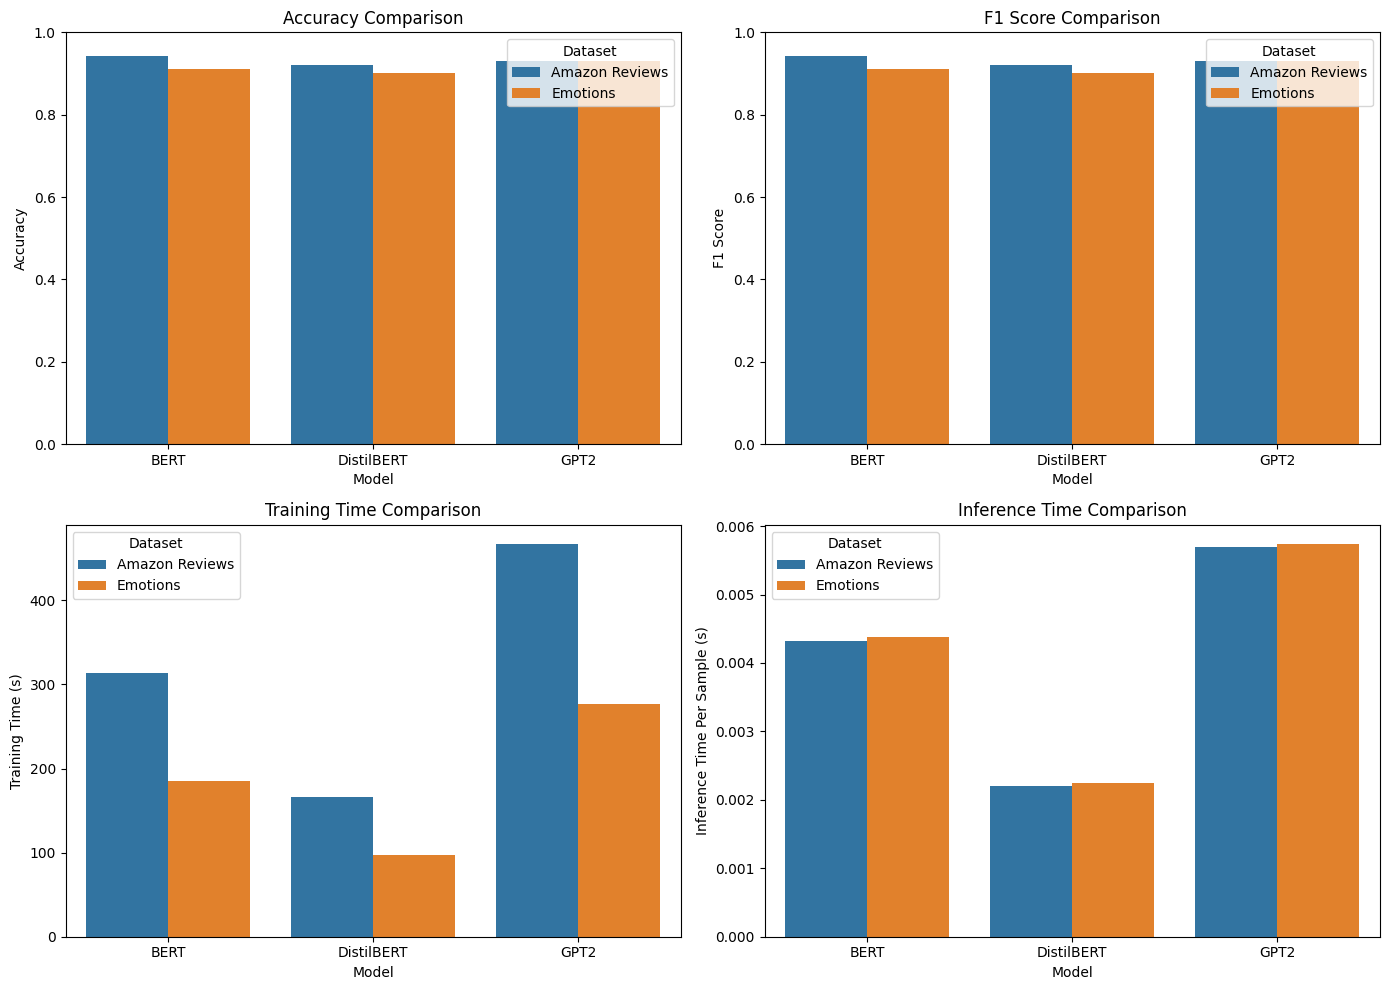

In [18]:
# Generate final report summarizing results
print("\n======= Generating Final Summary Report =======")

# Create a comprehensive summary table
summary = pd.DataFrame([
    # Amazon Reviews Models
    {'Dataset': 'Amazon Reviews', 'Model': 'BERT', 'Accuracy': bert_amazon_results['accuracy'], 
     'F1 Score': bert_amazon_results['f1_score'], 'Training Time (s)': bert_amazon_results['training_time'], 
     'Inference Time Per Sample (s)': bert_amazon_results['avg_inference_time_per_sample']},
    
    {'Dataset': 'Amazon Reviews', 'Model': 'DistilBERT', 'Accuracy': distilbert_amazon_results['accuracy'], 
     'F1 Score': distilbert_amazon_results['f1_score'], 'Training Time (s)': distilbert_amazon_results['training_time'], 
     'Inference Time Per Sample (s)': distilbert_amazon_results['avg_inference_time_per_sample']},
    
    {'Dataset': 'Amazon Reviews', 'Model': 'GPT2', 'Accuracy': gpt2_amazon_results['accuracy'], 
     'F1 Score': gpt2_amazon_results['f1_score'], 'Training Time (s)': gpt2_amazon_results['training_time'], 
     'Inference Time Per Sample (s)': gpt2_amazon_results['avg_inference_time_per_sample']},
    
    # Emotions Dataset Models
    {'Dataset': 'Emotions', 'Model': 'BERT', 'Accuracy': bert_emotions_results['accuracy'], 
     'F1 Score': bert_emotions_results['f1_score'], 'Training Time (s)': bert_emotions_results['training_time'], 
     'Inference Time Per Sample (s)': bert_emotions_results['avg_inference_time_per_sample']},
    
    {'Dataset': 'Emotions', 'Model': 'DistilBERT', 'Accuracy': distilbert_emotions_results['accuracy'], 
     'F1 Score': distilbert_emotions_results['f1_score'], 'Training Time (s)': distilbert_emotions_results['training_time'], 
     'Inference Time Per Sample (s)': distilbert_emotions_results['avg_inference_time_per_sample']},
    
    {'Dataset': 'Emotions', 'Model': 'GPT2', 'Accuracy': gpt2_emotions_results['accuracy'], 
     'F1 Score': gpt2_emotions_results['f1_score'], 'Training Time (s)': gpt2_emotions_results['training_time'], 
     'Inference Time Per Sample (s)': gpt2_emotions_results['avg_inference_time_per_sample']}
])

# Display the summary table
print("\nComprehensive Model Performance Summary:")
print(summary)

# Create summary visualizations
plt.figure(figsize=(14, 10))

# Accuracy comparison across datasets
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=summary)
plt.title('Accuracy Comparison')
plt.ylim(0, 1)

# F1 Score comparison across datasets
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='F1 Score', hue='Dataset', data=summary)
plt.title('F1 Score Comparison')
plt.ylim(0, 1)

# Training Time comparison
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Training Time (s)', hue='Dataset', data=summary)
plt.title('Training Time Comparison')

# Inference Time comparison
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Inference Time Per Sample (s)', hue='Dataset', data=summary)
plt.title('Inference Time Comparison')

plt.tight_layout()
plt.show()

In [19]:
# Display the best model for each metric
print("\nBest Models by Metric:")

# Best accuracy for Amazon Reviews
best_amazon_accuracy = summary[summary['Dataset'] == 'Amazon Reviews'].sort_values('Accuracy', ascending=False).iloc[0]
print(f"Best Accuracy (Amazon): {best_amazon_accuracy['Model']} - {best_amazon_accuracy['Accuracy']:.4f}")

# Best accuracy for Emotions
best_emotions_accuracy = summary[summary['Dataset'] == 'Emotions'].sort_values('Accuracy', ascending=False).iloc[0]
print(f"Best Accuracy (Emotions): {best_emotions_accuracy['Model']} - {best_emotions_accuracy['Accuracy']:.4f}")

# Best F1 for Amazon Reviews
best_amazon_f1 = summary[summary['Dataset'] == 'Amazon Reviews'].sort_values('F1 Score', ascending=False).iloc[0]
print(f"Best F1 Score (Amazon): {best_amazon_f1['Model']} - {best_amazon_f1['F1 Score']:.4f}")

# Best F1 for Emotions
best_emotions_f1 = summary[summary['Dataset'] == 'Emotions'].sort_values('F1 Score', ascending=False).iloc[0]
print(f"Best F1 Score (Emotions): {best_emotions_f1['Model']} - {best_emotions_f1['F1 Score']:.4f}")

# Fastest inference for Amazon Reviews
fastest_amazon = summary[summary['Dataset'] == 'Amazon Reviews'].sort_values('Inference Time Per Sample (s)').iloc[0]
print(f"Fastest Inference (Amazon): {fastest_amazon['Model']} - {fastest_amazon['Inference Time Per Sample (s)']:.6f} s")

# Fastest inference for Emotions
fastest_emotions = summary[summary['Dataset'] == 'Emotions'].sort_values('Inference Time Per Sample (s)').iloc[0]
print(f"Fastest Inference (Emotions): {fastest_emotions['Model']} - {fastest_emotions['Inference Time Per Sample (s)']:.6f} s")

# Display model agreement summary
print("\nModel Agreement Summary:")
print(f"All three models agree on {agreement_percentage:.2f}% of unlabeled data")
print(f"Highest agreement between: {agreement_data.iloc[1:].sort_values('Agreement (%)', ascending=False).iloc[0]['Comparison']} ({agreement_data.iloc[1:].sort_values('Agreement (%)', ascending=False).iloc[0]['Agreement (%)']:.2f}%)")

print("\n======= Analysis Complete =======")


Best Models by Metric:
Best Accuracy (Amazon): BERT - 0.9420
Best Accuracy (Emotions): GPT2 - 0.9311
Best F1 Score (Amazon): BERT - 0.9420
Best F1 Score (Emotions): GPT2 - 0.9307
Fastest Inference (Amazon): DistilBERT - 0.002208 s
Fastest Inference (Emotions): DistilBERT - 0.002246 s

Model Agreement Summary:
All three models agree on 100.00% of unlabeled data
Highest agreement between: BERT vs DistilBERT (100.00%)

======= Analysis Complete =======
